In [72]:
import numpy as np
import pandas as pd
import pickle as pic
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack, coo_matrix
from scipy.sparse import save_npz, load_npz
from sklearn.preprocessing import MaxAbsScaler
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

In [3]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('inputs/train.csv').fillna(' ')
test = pd.read_csv('inputs/test.csv').fillna(' ')

train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

In [4]:
train.shape

(95851, 8)

In [7]:
#word_vectorizer = TfidfVectorizer(
#    sublinear_tf=True,
#    strip_accents='unicode',
#    analyzer='word',
#    token_pattern=r'\w{1,}',
#    stop_words='english',
#    ngram_range=(1, 1),
#    max_features=10000)
#word_vectorizer.fit(all_text)
#train_word_features = word_vectorizer.transform(train_text)
#test_word_features = word_vectorizer.transform(test_text)

#print('unigrams Done')
#char_vectorizer = TfidfVectorizer(
#    sublinear_tf=True,
#    strip_accents='unicode',
#  analyzer='char',
#   stop_words='english',
#    ngram_range=(2, 6),
#    max_features=20000)
#char_vectorizer.fit(all_text)
#train_char_features = char_vectorizer.transform(train_text)
#test_char_features = char_vectorizer.transform(test_text)
#print('ngrams done')

In [11]:
word_vectorizer = pic.load( open( "inputs/word_vectorizer.p", "rb" ) )
train_word_features = pic.load( open( "inputs/train_word_features.p", "rb" ) )
test_word_features = pic.load( open( "inputs/test_word_features.p", "rb" ) )

char_vectorizer = pic.load( open( "inputs/char_vectorizer.p", "rb" ) )
train_char_features = pic.load( open( "inputs/train_char_features.p", "rb" ) )
test_char_features = pic.load( open( "inputs/test_char_features.p", "rb" ) )

In [40]:
### Features Engineered based on EDA

train['total_length'] = train['comment_text'].apply(len)

test['total_length'] = test['comment_text'].apply(len)

train['capitals'] = train['comment_text'].apply(
    lambda comment: sum(1 for c in comment if c.isupper()))

test['capitals'] = test['comment_text'].apply(
    lambda comment: sum(1 for c in comment if c.isupper()))


# Features

train['exc_density'] = train['comment_text'].map(lambda x: x.count('!')/len(x))

test['exc_density'] = test['comment_text'].map(lambda x: x.count('!')/len(x))

train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(
    row['total_length']),axis=1)

test['caps_vs_length'] = test.apply(lambda row: float(row['capitals'])/float(
    row['total_length']),axis=1)


train['num_unique_words'] = train['comment_text'].apply(
    lambda comment: len(set(w for w in comment.split())))

test['num_unique_words'] = test['comment_text'].apply(
    lambda comment: len(set(w for w in comment.split())))

In [41]:
# Data validation

def notvalid(x):
    return x.isnull().sum()

print(np.sum(notvalid(train['exc_density'])))
print(np.sum(notvalid(test['exc_density'])))
print(np.sum(notvalid(train['capitals'])))
print(np.sum(notvalid(test['capitals'])))
print(np.sum(notvalid(train['total_length'])))
print(np.sum(notvalid(test['total_length'])))
print(np.sum(notvalid(train['caps_vs_length'])))
print(np.sum(notvalid(test['caps_vs_length'])))
print(np.sum(notvalid(train['num_unique_words'])))
print(np.sum(notvalid(test['num_unique_words'])))


0
0
0
0
0
0
0
0
0
0


In [42]:
#Added to Sparse Matrix


train_features = hstack([train_char_features, train_word_features,
                         np.array(train['exc_density'])[:,None],
                         np.array(train['caps_vs_length'])[:,None],
                         np.array(train['num_unique_words'])[:,None]
                         ])

In [43]:
#Added to Sparse Matrix

test_features = hstack([test_char_features, test_word_features,
                         np.array(test['exc_density'])[:,None],
                         np.array(test['caps_vs_length'])[:,None],
                         np.array(test['num_unique_words'])[:,None]
                         ])

In [44]:
save_npz('inputs/train_sparse.npz', train_features)

In [45]:
# Using Training Data portion as test data
save_npz('inputs/test_sparse.npz', test_features)

In [46]:
test_features = load_npz('inputs/test_sparse.npz')

train_features = load_npz('inputs/train_sparse.npz')

In [47]:
test_features = MaxAbsScaler().fit_transform(test_features)

train_features = MaxAbsScaler().fit_transform(train_features)

In [48]:
### Break into training and Validation Sets. Test set in this case is for 
# submission to Competition

train_features, val_features, train, val_y = train_test_split(train_features,train,
                                                                test_size=0.05, 
                                                               random_state=666)

# Saves the broken up training set. 
save_npz('inputs/val_sparse.npz', val_features)
val_y.to_csv('inputs/val_data.csv')
save_npz('inputs/train_cv_sparse.npz', train_features)
train.to_csv('inputs/train_cv.csv')

In [49]:
val_features

<4793x30003 sparse matrix of type '<class 'numpy.float64'>'
	with 4045356 stored elements in Compressed Sparse Row format>

In [50]:
train_features

<91058x30003 sparse matrix of type '<class 'numpy.float64'>'
	with 76769447 stored elements in Compressed Sparse Row format>

In [52]:
val_y

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_length,capitals,exc_density,caps_vs_length,num_unique_words
13607,140644985663,Good to see the neo-Nazi Wikipedia editors all...,1,0,0,0,0,0,311,16,0.006431,0.051447,46
52030,542817525829,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0,181,5,0.000000,0.027624,28
20855,215610410463,"and BTW, I created an account in the french wi...",0,0,0,0,0,0,885,44,0.021469,0.049718,108
27838,288516637962,"""\n Nevertheless, it is still an offensive ter...",0,0,0,0,0,0,182,3,0.010989,0.016484,31
33228,345486755723,"2006 (UTC)d\nIt doesn't matter, it's all lopsi...",0,0,0,0,0,0,106,5,0.018868,0.047170,17
67017,698038087297,"""\n\n Bristol City Museum and Art Gallery \n\n...",0,0,0,0,0,0,485,20,0.000000,0.041237,69
57758,601871846089,"| decline=A bit too close for comfort, that on...",0,0,0,0,0,0,163,3,0.000000,0.018405,25
75895,790521065090,Dude! \nThat was an attempt at saying somethi...,0,0,0,0,0,0,152,4,0.013158,0.026316,26
64448,671587944326,"Picture of the band \n\nWell, Kjoonlee, that's...",0,0,0,0,0,0,289,12,0.000000,0.041522,43
9222,95196799279,p.s.\nwikipedia is not for freedom of speech o...,0,0,0,0,0,0,471,0,0.000000,0.000000,68


In [53]:
scores = []
cv_scores = []
submission = pd.DataFrame.from_dict({'id': test['id']})


for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(solver='sag')
    cv_score = np.mean(cross_val_score(classifier, train_features, train_target,
                                       cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    cv_scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    classifier.fit(train_features, train_target)
    filename = "Model_W/"+class_name+"_LR.sav"
    joblib.dump(classifier, filename)
    
    #submission[class_name] = classifier.predict_proba(test_features)[:, 1]
    


print('Total CV score is {}'.format(np.mean(scores)))
#submission.to_csv('submissions/submission_LR.csv', index=False)

e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class toxic is 0.9643763554815866


e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class severe_toxic is 0.9717628368896962


e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class obscene is 0.9767436168856527


e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class threat is 0.9663818019396024


e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class insult is 0.9647201805931293


e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
e:\david\python\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CV score for class identity_hate is 0.9550347470578403
Total CV score is 0.9665032564745846


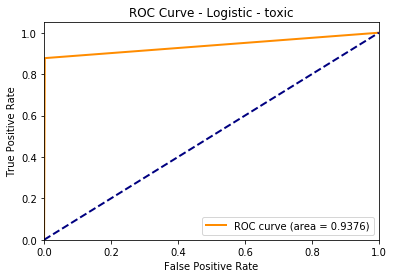

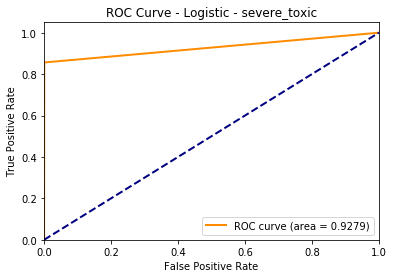

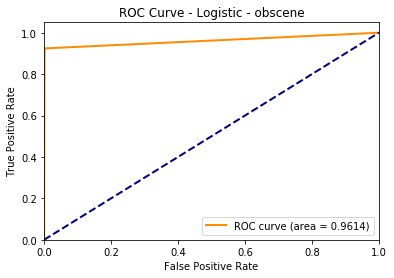

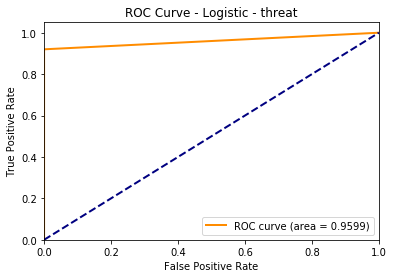

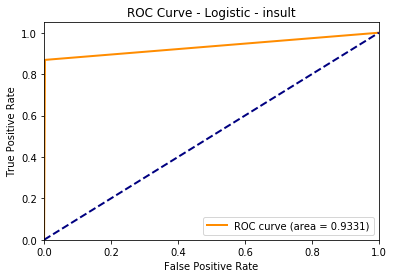

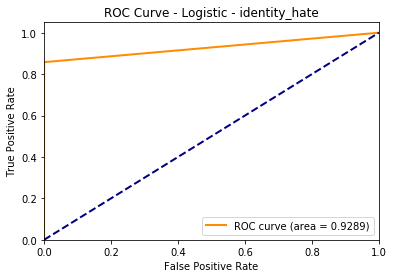

In [71]:
# Plot ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_name in class_names:
    filename = "Model_W/"+class_name+"_LR.sav"
    classifier = joblib.load(filename)
    
    train_target = train[class_name]
    train_pred = classifier.predict(train_features)

    fpr[class_name], tpr[class_name], _ = roc_curve(train_target, train_pred)
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])
    
    plt.figure()
    lw=2
    plt.plot(fpr[class_name], tpr[class_name], color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[class_name])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic - {0}'.format(class_name))
    plt.legend(loc="lower right")
    plt.savefig('Plots/ROC_LOG_{0}.png'.format(class_name))
    plt.show()

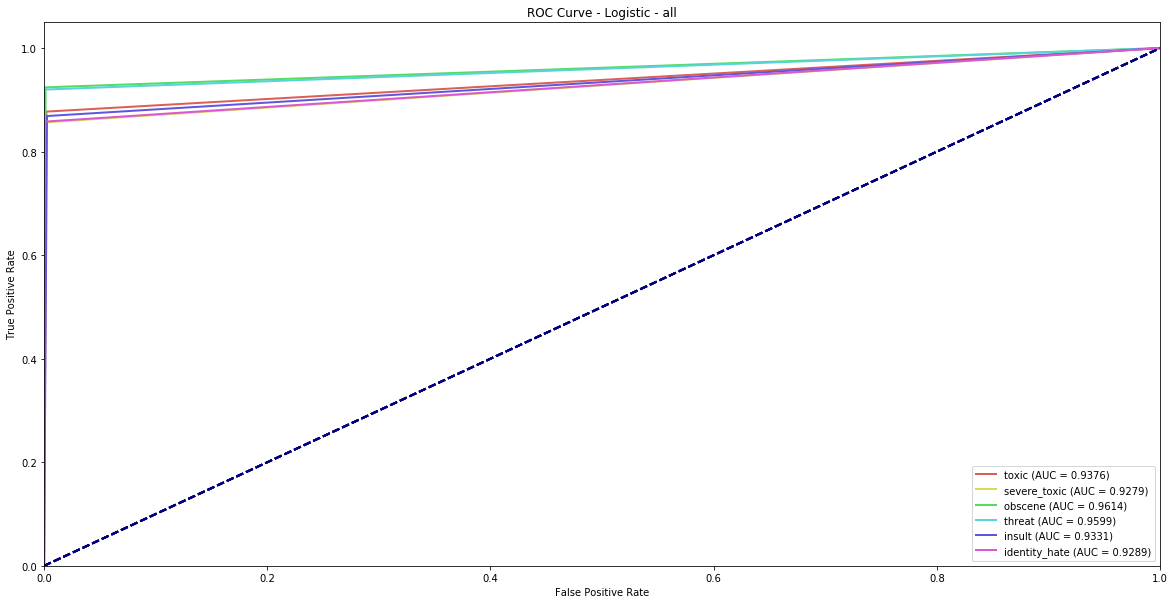

In [75]:
colors = sns.color_palette("hls",6)

plt.figure(figsize=(20,10))
for idx, class_name in enumerate(class_names):
    filename = "Model_W/"+class_name+"_LR.sav"
    classifier = joblib.load(filename)
    
    train_target = train[class_name]
    train_pred = classifier.predict(train_features)

    fpr[class_name], tpr[class_name], _ = roc_curve(train_target, train_pred)
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])
    
    lw=2
    plt.plot(fpr[class_name], tpr[class_name], color=colors[idx],
         lw=lw, label='%s (AUC = %0.4f)' % (class_name,roc_auc[class_name]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic - all')
    plt.legend(loc="lower right")

plt.savefig('Plots/ROC_LOG_all.png')
plt.show()

In [ ]:
scores

In [ ]:
val_y[class_name].head()

In [ ]:
print(class_name)

classifier.score(val_features, val_y[class_name])